In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Dataset
## 1.1 Problem
- Translate **human language date** to a `machine standard date` format
- Eg:
    + **the 29th of August 1958** -> `1958-08-29`
    + **03/30/1968**              -> `1968-03-30`
    + **24 JUNE 1987**            -> `1987-06-24`

In [2]:
from babel.dates import format_date
from faker import Faker
import random

# data generator
fake = Faker()

date_formats = ['short', 'medium', 'long',
    'full', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 'full',
    'd MMM YYY',  'd MMMM YYY', 'dd MMM YYY', 'd MMM, YYY', 'd MMMM, YYY', 'dd, MMM YYY',
    'd MM YY', 'd MMMM YYY', 'MMMM d YYY', 'MMMM d, YYY', 'dd.MM.YY']

def generate_training_example():
    # Get a random date (standard format)
    machine_date = fake.date_object()
    
    # Generate a human readable format
    human_readable = format_date(machine_date, format=random.choice(date_formats), locale='en_US') \
        .lower().replace(',','')
    
    return human_readable, machine_date.isoformat()

In [3]:
for i in range(5):
    human, machine = generate_training_example()
    print(f'{human:30} -> {machine}')

july 6 1991                    -> 1991-07-06
26 mar 1986                    -> 1986-03-26
march 16 2007                  -> 2007-03-16
06 dec 1986                    -> 1986-12-06
tuesday april 9 1991           -> 1991-04-09


#### Generate training set

In [4]:
def generate_dset(m=10000):
    X, Y = [], []
    for i in range(m):
        x, y = generate_training_example()
        X.append(x)
        Y.append(y)
    return X, Y

In [5]:
X, Y = generate_dset(m=10000)

X_train, Y_train = X[:8000], Y[:8000]
X_test, Y_test = X[8000:], Y[8000:]

print(X_train[:5])
print(Y_train[:5])

['sunday march 9 1997', '27 march 1998', 'friday august 25 1995', '30 may 2015', 'wednesday october 25 2000']
['1997-03-09', '1998-03-27', '1995-08-25', '2015-05-30', '2000-10-25']


## 1.2 Lexicon

In [6]:
X_chars = sorted(list(set(''.join(X_train)))) + ['<unk>', '<pad>', '<start>', '<end>']
X_lexicon = { ch:idx for idx, ch in enumerate(X_chars) }
X_lexicon_size = len(X_lexicon)

print('X lexicon size:', X_lexicon_size)
print(X_lexicon)

X lexicon size: 39
{' ': 0, '.': 1, '/': 2, '0': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, 'a': 13, 'b': 14, 'c': 15, 'd': 16, 'e': 17, 'f': 18, 'g': 19, 'h': 20, 'i': 21, 'j': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'r': 28, 's': 29, 't': 30, 'u': 31, 'v': 32, 'w': 33, 'y': 34, '<unk>': 35, '<pad>': 36, '<start>': 37, '<end>': 38}


In [7]:
Y_chars = sorted(list(set(''.join(Y_train)))) + ['<unk>', '<pad>', '<start>', '<end>']

Y_lexicon         = { ch:idx for idx, ch in enumerate(Y_chars) }
Y_lexicon_size    = len(Y_lexicon)
Y_inverse_lexicon = { idx:ch for idx, ch in enumerate(Y_chars) }


print('Y lexicon size:', Y_lexicon_size)
print(f'{Y_lexicon = }')
print(f'{Y_inverse_lexicon = }')

Y lexicon size: 15
Y_lexicon = {'-': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10, '<unk>': 11, '<pad>': 12, '<start>': 13, '<end>': 14}
Y_inverse_lexicon = {0: '-', 1: '0', 2: '1', 3: '2', 4: '3', 5: '4', 6: '5', 7: '6', 8: '7', 9: '8', 10: '9', 11: '<unk>', 12: '<pad>', 13: '<start>', 14: '<end>'}


# 2. Feature Engineering

In [8]:
from joblib import Parallel, delayed


def get_feat_tensor(data, lexicon, pad_length=30):
    """
    Arguments:
        data    (list(str))         : input data list of utterances
        lexicon (dict(char:index))  : lexicon data, categorical encoding char to int
        pad_length (int)            : padded length of output utterance 

    Returns:
        data_tensor (ndarray (m, pad_length)) : output tensor with
            <m> training seamples
            <pad_length> padded utterance size
    """

    # Pipeline for each utterance
    def get_utt_tensor(utt:str):
        # Tokenize: char to int
        utt_tensor = [ lexicon['<start>'] ] + \
            [ lexicon[ch] if lexicon.get(ch) is not None
                else lexicon['<unk>']
                    for ch in utt ] + \
            [ lexicon['<end>'] ]

        # padding
        utt_tensor = utt_tensor[:pad_length]
        if len(utt_tensor) < pad_length:
            utt_tensor += [lexicon['<pad>']]*(pad_length - len(utt_tensor))

        return np.array(utt_tensor)

    # Convert m examples
    tensor = Parallel(n_jobs=16)(delayed(function=get_utt_tensor)(utt)
        for utt in data)
    return np.array(tensor)

In [9]:
# Fixed sequence length
Tx = 32
Ty = 12

X_train_ts = get_feat_tensor(X_train, X_lexicon, pad_length=Tx)
Y_train_ts = get_feat_tensor(Y_train, Y_lexicon, pad_length=Ty)

X_test_ts = get_feat_tensor(X_test, X_lexicon, pad_length=Tx)
Y_test_ts = get_feat_tensor(Y_test, Y_lexicon, pad_length=Ty)

# X_train = (m, Tx)
print(X_train_ts.shape)

# Y_train = (m, Ty)
print(Y_train_ts.shape)
print('Y[0] =', Y_train_ts[0])

(8000, 32)
(8000, 12)
Y[0] = [13  2 10 10  8  0  1  4  0  1 10 14]


# 2. Model

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## 2.1 Components

#### Encoder

In [11]:
class Encoder(nn.Module):
    def __init__(self, X_lexicon_size):
        super(Encoder, self).__init__()

        # params
        self.emb_dim = 64
        self.hid_feat_dim = 128
        self.num_layers = 1
        
        # Emb
        self.embedding = nn.Embedding(
            num_embeddings=X_lexicon_size,
            embedding_dim=self.emb_dim)

        # enc
        self.encoder = nn.LSTM(
            input_size=self.emb_dim,
            hidden_size=self.hid_feat_dim,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=True, dropout=0)

    def forward(self, X, device='cpu'):
        """
        Arguments:
            X (Longtensor(m, Tx))                : Input Sequence, type=Long
                m: batch_size,
                Tx: sequence length 
        Returns:
            o_enc (tensor(m, Tx, 2*hid_dim))         : Encoder output states (bi-directional)
            h_enc (tensor(2*num_layers, m, hid_dim)) : Encoder hidden states (bi-directional)
            c_enc (tensor(2*num_layers, m, hid_dim)) : Encoder cell states (bi-directional)
        """
        # get batchsize
        m = X.size(0)

        # Embedding
        #    (m, Tx) -> (m, Tx, emb_dim)
        emb = self.embedding(X)
        emb = F.relu(emb)
    
        # Init h0, c0
        #   (2, m, hid_dim)
        h0 = torch.zeros(2*self.num_layers, m, self.hid_feat_dim) \
            .float().to(device)
        c0 = torch.zeros(2*self.num_layers, m, self.hid_feat_dim) \
            .float().to(device)

        # Encode
        #   o_enc: (m, Tx, 2*hid_dim)
        #   h_enc/c_enc: (2, m, hid_dim)
        o_enc, (h_enc, c_enc) = self.encoder(emb, (h0, c0))
        return o_enc, (h_enc, c_enc)

In [12]:
X = torch.LongTensor(X_train_ts[:16])

encoder = Encoder(X_lexicon_size=39)
o_enc, (h_enc, c_enc) = encoder(X)

print(f'{o_enc.size() = }')
print(f'{h_enc.size() = }, {c_enc.size() = }')

o_enc.size() = torch.Size([16, 32, 256])
h_enc.size() = torch.Size([2, 16, 128]), c_enc.size() = torch.Size([2, 16, 128])


#### Attention - [https://arxiv.org/pdf/1409.0473.pdf](https://arxiv.org/pdf/1409.0473.pdf)

<img src="./assets/seq2seq_attention.jpg" width="300"/>

- Energy $e_{ij}$
    + $[]$: concat ops
        + $h_j$: previous decoder hidden state
        + $s_{i-1}$: encoder output states
    + $f()$: attention function
  
$$e_{ij} = f( [h_j, s_{i-1}] )$$

- Attention (weights)

$$\alpha_{ij} = \text{softmax}(e_{ij}) = \frac{exp(e_{ij})}{\sum\limits_{k=1}^{Tx}exp(e_{ik})}$$

- context vector: **Tell decoder which parts of hidden state which it should pay more attention (weights) to**
    $$c_i = \sum\limits_{j=1}^{Tx} \alpha_{ij}h_j$$

In [13]:
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()

        # params
        self.hid_feat_dim = 128

        # Aggregate hidden state
        self.agg_hidden_fc = nn.Linear(
            in_features=2*self.hid_feat_dim,
            out_features=self.hid_feat_dim)

        # Attention function
        self.att_fc = nn.Linear(
            in_features=3*self.hid_feat_dim,
            out_features=1)

    def forward(self, enc_states, ht_dec):
        """
        Arguments:
            enc_states (tensor(m, Tx, 2*hid_dim))     : Encoder output states (bi-directional)
            ht_dec (tensor(2*num_layers, m, hid_dim)) : Previous decoder hidden states (bi-directional)
        Returns:
            context_vector (tensor(m, 1, 2*hid_dim))  : Context vector
        """
        # get dims: batch_size, sequence_size
        m, Tx = enc_states.size(0), enc_states.size(1)

        #### Aggregate
        # Aggregate ht_dec (bi-directional to 1 dir)
        #    (2, m, hid_dim) -> (m, 2*hid_dim) -> (m, hid_dim) 
        ht_dec_agg = self.agg_hidden_fc(
            torch.cat([ht_dec[0], ht_dec[1]], dim=1))

        #### Attention
        # Reshape ht_dec
        #    (m, hid_dim) -> (m, 1, hid_dim) -> (m, Tx, hid_dim) 
        ht_reshaped = torch.unsqueeze(ht_dec_agg, dim=1) \
            .repeat(1,Tx,1)

        # Compute energy e_ij
        #   (m, Tx, hid_dim) + (m, Tx, 2*hid_dim) -> (m, Tx, 3*hid_dim)
        concat = torch.cat([ht_reshaped, enc_states], dim=2)
        #   (m, Tx, 3*hid_dim) -> (m, Tx, 1)
        energy = F.relu(self.att_fc(concat))

        # Compute attention alpha_ij: (m, Tx, 1)
        alpha = F.softmax(energy, dim=2)

        # Compute context vector
        #   (m, Tx, 1) x (m, Tx, hid_dim) -> (m, 1, 2*hid_dim)
        context_vector = torch.einsum("mTk,mTn->mkn", alpha, enc_states)
        return context_vector

In [14]:
attention = Attention()

context = attention(
    enc_states=o_enc,
    ht_dec=h_enc)

print(f'{context.size() = }')

context.size() = torch.Size([16, 1, 256])


#### Decoder

In [15]:
class Decoder(nn.Module):
    def __init__(self, Y_lexicon_size):
        super(Decoder, self).__init__()

        # params
        self.emb_dim = 64
        self.hid_feat_dim = 128
        self.num_layers = 1

        # Emb
        self.embedding = nn.Embedding(
            num_embeddings=Y_lexicon_size,
            embedding_dim=self.emb_dim)

        # Decoder
        self.decoder = nn.LSTM(
            input_size=2*self.hid_feat_dim + self.emb_dim,
            hidden_size=self.hid_feat_dim,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=True, dropout=0)

        self.fc = nn.Linear(
            in_features=2*self.hid_feat_dim,
            out_features=Y_lexicon_size)

    def forward(self, yt_prev, context_vector, ht_dec, ct_dec):
        """
        Arguments:
            yt_prev (Long tensor(m))  : Output sequence at prev time step (t-1), categorical Long
                m: batchsize
            context_vector (tensor(m, 1, 2*hid_dim))          : Context vector from attention mechanism
            ht_dec, ct_dec (tensor(2*num_layers, m, hid_dim)) : Previous decoder hidden/cell states (t-1) (bi-directional)
        Returns:
            yt_hat (tensor(m, Y_lexicon_size))                : y_hat at timestep t, out_dim = Y_lexicon_size
            ht_dec, ct_dec (tensor(2*num_layers, m, hid_dim)) : decoder hidden/cell states at current timestep t (bi-directional)
        """
        # (m) -> (m, 1)
        yt_prev = yt_prev.unsqueeze(dim=1)

        # Embedding
        #    (m, 1) -> (m, 1, emb_dim)
        emb = self.embedding(yt_prev)
        emb = F.relu(emb)

        # Decode
        #   (m,1,2*hid_dim) + (m,1,emb_dim) -> (m,1,2*hid_dim + emb_dim)
        concat = torch.cat([context_vector, emb], dim=2)
        #   o_dec:         (m, 1, 2*hid_dim)
        #   ht_dec/ct_dec: (2, m, hid_dim)
        o_dec, (ht_dec, ct_dec) = self.decoder(concat, (ht_dec, ct_dec))

        # Predict y_hat
        #   (m, 1, 2*hid_dim) -> (m, 1, y_lexicon_dim) -> (m, y_lexicon_dim)
        yt_hat = self.fc(o_dec).squeeze(dim=1)
        yt_hat = F.log_softmax(yt_hat, dim=1)

        return yt_hat, ht_dec, ct_dec

In [16]:
Y = torch.LongTensor(Y_train_ts[:16])
y0 = Y[:, 0]
print(f'{Y.size() = }, {y0.size() = }')

decoder = Decoder(Y_lexicon_size=15)
y1_hat, ht_dec, ct_dec = decoder(yt_prev=y0,
    context_vector=context,
    ht_dec=h_enc, ct_dec=c_enc)

print(f'{y1_hat.size() = }')

Y.size() = torch.Size([16, 12]), y0.size() = torch.Size([16])
y1_hat.size() = torch.Size([16, 15])


## 2.2 Models
- Apply context vector to all decoder hidden states

<img src="./assets/seq2seq_context.png" width="600"/>


In [17]:
import random


class Seq2Seq(nn.Module):
    def __init__(self, X_lexicon_size, Y_lexicon_size):
        super(Seq2Seq, self).__init__()
        # Params
        self.Y_lexicon_size = Y_lexicon_size

        self.encoder = Encoder(X_lexicon_size=X_lexicon_size)
        self.attention = Attention()
        self.decoder = Decoder(Y_lexicon_size=Y_lexicon_size)

    def forward(self, X, Y,
            device='cpu', teacher_force_ratio=0.5):
        """
        Arguments:
            X (Long tensor(m, Tx))        : Input sequence
            Y (Long tensor(m, Ty))        : Output sequence
            teacher_force_ratio (float)   : teaching forcing probability in range [0,1]
        Returns:
            Y_hat (tensor(m, Ty, Y_lexicon_size)): Y_hat, out_dim = Y_lexicon_size
        """
        # Get dim
        m, Ty = Y.size(0), Y.size(1)

        # Encode
        enc_out, (h_enc, c_enc) = self.encoder(X, device=device)

        # Init yt_prev = <start>, long tensor (m,)
        yt_prev = Y[:, 0]

        # Init h_dec, c_dec
        ht_dec, ct_dec = h_enc, c_enc

        # Predict next timestep
        Y_hat = torch.zeros(m, Ty, self.Y_lexicon_size).to(device)
        for t in range(1, Ty):
            # Attention
            context = self.attention(
                enc_states=enc_out,
                ht_dec=ht_dec)

            # Decode
            Y_hat[:,t,:] , ht_dec, ct_dec = self.decoder(
                yt_prev=yt_prev,
                context_vector=context,
                ht_dec=ht_dec, ct_dec=ct_dec)

            # Teaching forcing:
            #   prob:      Force yt_prev = Y[t+1]
            #   1 - prob:  get prediction from model
            if random.random() < teacher_force_ratio:
                yt_prev = Y[:,t]
            else:
                yt_prev = Y_hat[:,t,:].argmax(dim=1)

        return Y_hat

In [18]:
net = Seq2Seq(X_lexicon_size=39, Y_lexicon_size=15)
Y_hat = net(X, Y)

print(f'{Y_hat.size() = }')

Y_hat.size() = torch.Size([16, 12, 15])


# 3. Train

In [19]:
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

def fit(
        X, Y,
        X_lexicon_size, Y_lexicon_size, Y_pad_token,
        alpha=1e-2, num_iters=1000, batch_size=16, teacher_force_ratio=0.5):
    """
    Arguments:
        X (ndarray(m, Tx))      : Input sequence
        Y (ndarray(m, Ty))      : Output sequence
        X_lexicon_size (int)    : Input sequence feat_dim = size of vocab X.
        Y_lexicon_size (int)    : Output sequence feat_dim = size of vocab Y.
        Y_pad_token (int)       : Padding token of target sequence, ignore when computing cost
    Returns:
        net (torch model)       : trained seq2seq model
        J_history (list)        : List of cost each iter for plotting
    """
    # Dataset
    dset = TensorDataset(
        torch.LongTensor(X),
        torch.LongTensor(Y))

    # Dataloader
    dloader = DataLoader(
        dataset=dset,
        batch_size=batch_size)

    ## Config
    device = torch.device(
        "cuda" if torch.cuda.is_available() else "cpu")

    # Model
    net = Seq2Seq(
        X_lexicon_size=X_lexicon_size,
        Y_lexicon_size=Y_lexicon_size)
    net = net.to(device)
    net.train()

    # Criterions
    #    Note: Exclude padding token when compte loss
    criterion = nn.NLLLoss(
        ignore_index=Y_pad_token)
    optimizer = torch.optim.Adam(net.parameters(), lr=alpha)

    # cost and params history
    J_history = []
    for i in range(num_iters):
        cost = 0
        for b, batch in enumerate(dloader):
            # Batch:
            #    X_b = (batch_size, Tx)
            #    Y_b = (batch_size, Ty)
            Xb, Yb = batch
            Xb = Xb.to(device).to(torch.int64)
            Yb = Yb.to(device).to(torch.int64)

            # Forward
            #    Yb_hat = (batch_size, Ty, Y_lexicon_size)
            optimizer.zero_grad()
            Yb_hat = net(Xb, Yb,
                device=device, teacher_force_ratio=teacher_force_ratio)

            # Batch Cost compute, t=1 skip <start>
            Yb_hat_reshaped = Yb_hat[:,1:,:].reshape(-1, Y_lexicon_size)
            Yb_reshaped = Yb[:,1:].reshape(-1)

            cost_b = criterion(Yb_hat_reshaped, Yb_reshaped)

            # Track Iter Cost
            cost += cost_b.item()

            # Back Propagation
            cost_b.backward()
            optimizer.step()

            # Clip grad to avoid exploding gradient
            nn.utils.clip_grad_norm_(net.parameters(), max_norm=1)

        # Compute Cost
        J_history.append(cost)
        if i % 10 == 0 or i == num_iters-1:
            print(f"Cost after iteration {i:4}: {cost:.4f}")
    return net, J_history

In [20]:
print(f'{Tx = }, {X_lexicon_size = }')
print(f'{Ty = }, {Y_lexicon_size = }')

model, J_hist = fit(
    X=X_train_ts, Y=Y_train_ts,
    X_lexicon_size=X_lexicon_size,
    Y_lexicon_size=Y_lexicon_size, Y_pad_token=Y_lexicon['<pad>'],
    alpha=1e-3, num_iters=100, batch_size=256,
    teacher_force_ratio=0.5)

Tx = 32, X_lexicon_size = 39
Ty = 12, Y_lexicon_size = 15
Cost after iteration    0: 68.0405
Cost after iteration   10: 9.1068
Cost after iteration   20: 1.7712
Cost after iteration   30: 0.4075
Cost after iteration   40: 0.2108
Cost after iteration   50: 0.0707
Cost after iteration   60: 0.0386
Cost after iteration   70: 0.0221
Cost after iteration   80: 0.0143
Cost after iteration   90: 0.0099
Cost after iteration   99: 0.0073


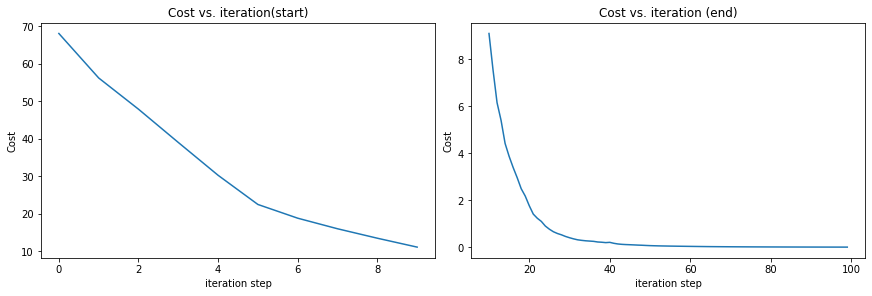

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12,4))

ax1.plot(J_hist[:10])
ax2.plot(10 + np.arange(len(J_hist[10:])), J_hist[10:])
ax1.set_title("Cost vs. iteration(start)");  ax2.set_title("Cost vs. iteration (end)")
ax1.set_ylabel('Cost')            ;  ax2.set_ylabel('Cost')
ax1.set_xlabel('iteration step')  ;  ax2.set_xlabel('iteration step')
plt.show()

# 4. Inference

#### Infer input

In [22]:
def infer(model, input_sentence, X_lexicon, Y_inverse_lexicon, Tx=32, Ty=12):
    """
    Arguments:
        model (torch model)                 : trained seq2seq model
        input_sentence (str)                : Input human readable format
        X_lexicon (dict(ch:idx))            : Human dictionary
        Y_inverse_lexicon (dict(idx:ch))    : Machine inverse dictionary
    Returns:
        output_sentence (str)               : Predicted machine readable format from model
    """
    model.cpu()
    with torch.no_grad():
        # str -> [37,2,1,56,38] -> tensor(1, Tx)
        X_tensor = torch.LongTensor(
            get_feat_tensor([input_sentence], X_lexicon, pad_length=Tx))

        # infer: Y_hat = (1, Ty, Y_lexicon_size)
        m = X_tensor.size(0)
        Y_dummy = torch.zeros(m, Ty).to(torch.int64)
        Y_hat = model(X_tensor, Y_dummy,
            device='cpu', teacher_force_ratio=0)

        # predict
        output_sentence = ''

        # (1, Ty, Y_lexicon_size) -> (1, Ty) -> (Ty)
        y_seq = torch.argmax(Y_hat, dim=2).squeeze(dim=0)
        y_seq = y_seq.numpy().tolist()

        # skip <start>
        for idx in y_seq[1:]:
            if Y_inverse_lexicon[idx] == '<end>': break
            output_sentence += Y_inverse_lexicon[idx]
        return output_sentence

In [23]:
print(f'{"[Input]":30} {"[Prediction]":15} {"[Correct Label]":15}')
for i in range(10):
    pred = infer(model, X_test[i],
        X_lexicon=X_lexicon, Y_inverse_lexicon=Y_inverse_lexicon,
        Tx=Tx, Ty=Ty)
    print(f'{X_test[i]:30} {pred:15} {Y_test[i]:15}')

[Input]                        [Prediction]    [Correct Label]
4 july 1993                    1993-07-04      1993-07-04     
saturday june 21 1997          1997-06-21      1997-06-21     
27 08 15                       2015-08-27      2015-08-27     
14 05 87                       1987-05-14      1987-05-14     
july 16 2022                   2022-07-16      2022-07-16     
18 jun 1982                    1982-06-18      1982-06-18     
friday february 15 1974        1974-02-15      1974-02-15     
31.08.09                       2009-08-31      2009-08-31     
thursday april 28 1994         1994-04-28      1994-04-28     
5 november 1983                19831-11-05     1983-11-05     


#### Accuracy

In [24]:
# Predict
Y_test_pred = Parallel(n_jobs=16)(delayed(function=infer)(model, utt,
    X_lexicon=X_lexicon, Y_inverse_lexicon=Y_inverse_lexicon, Tx=Tx, Ty=Ty)
        for utt in X_test)

# Acc
scores = [ 1 if Y_test_pred[i] == Y_test[i] else 0 \
    for i in range(len(Y_test)) ]
print(f'Test accuracy = {100.0*sum(scores)/len(Y_test):.3f}%')

Test accuracy = 95.100%
